# PhyloBayes estimation of amino-acids preferences 
    
      1. Download coding sequence alignment and corresponding newick tree
      2. Estimate site-specific amino-acid preferences with PhyloBayes using the alignment.
      3. Plot the estimated site-specific amino-acid preferences with DMS_tools.

**Requirements:**
- PhyloBayes MPI for inference: https://github.com/bayesiancook/pbmpi
- DMS_tools for visualisation: https://jbloomlab.github.io/dms_tools/index.html

**Quick installation on ubuntu linux:**

Open a terminal and run the following commands to install packages

 - sudo apt install python-pip
 - sudo apt install libopenmpi-dev
 - sudo apt install openmpi-bin
 - sudo apt install git
 - sudo apt install curl
 - sudo apt install p7zip-full

Then install DMS_tools and PhyloBayes

In [1]:
# Install DMS_tools with pip
!pip install dms_tools --user

# Compiling PhyloBayes MPI
!git clone https://github.com/bayesiancook/pbmpi
%cd pbmpi/sources
!make
%cd ../..

Cloning into 'pbmpi'...
remote: Enumerating objects: 1846, done.
remote: Total 1846 (delta 0), reused 0 (delta 0), pack-reused 1846
Receiving objects: 100% (1846/1846), 20.01 MiB | 1.79 MiB/s, done.
Resolving deltas: 100% (1437/1437), done.
/home/thibault/SimuEvol/notebooks/pbmpi/sources
Generating dependencies for GTRSubMatrix.cpp...
Generating dependencies for NNI.cpp...
Generating dependencies for gamma.cpp...
Generating dependencies for CodonMutSelProfileProcess.cpp...
Generating dependencies for GeneralPathSuffStatGTRProfileProcess.cpp...
Generating dependencies for PoissonSBDPProfileProcess.cpp...
Generating dependencies for RASCATGTRDPGammaPhyloProcess.cpp...
Generating dependencies for PoissonDPProfileProcess.cpp...
Generating dependencies for PoissonMixtureProfileProcess.cpp...
Generating dependencies for SubstitutionProcess.cpp...
Generating dependencies for Random.cpp...
Generating dependencies for MatrixFiniteProfileProcess.cpp...
Generating dependencies for BPCompare.cpp..

## Download data

If one already has a .fasta alignment file and a .newick species tree file, this step can be skipped.

As an example, we use dataset from: <br>
Bloom, J. D. (2017). Identification of positive selection in genes is greatly improved by using experimentally informed site-specific models. *Biology direct, 12(1), 1.* 
https://doi.org/10.1186/s13062-016-0172-z.

**Requirements:**
- curl
- 7z: installed by p7zip-full

In [5]:
# Additional file 12. The data and code for running the analysis for lactamase. This is a 7-Zip file containing an iPython notebook and the relevant data files. (7z 2692 kb)
SM12_link = "https://static-content.springer.com/esm/art%3A10.1186%2Fs13062-016-0172-z/MediaObjects/13062_2016_172_MOESM12_ESM.7z"

# Download the additional file with curl
!curl {SM12_link} --output SM12.7z

# Unzip the file with 7z
!7z -y x SM12.7z

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2691k  100 2691k    0     0  2161k      0  0:00:01  0:00:01 --:--:-- 2161k

7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,8 CPUs Intel(R) Core(TM) i7-6700HQ CPU @ 2.60GHz (506E3),ASM,AES-NI)

Scanning the drive for archives:
  0M Sca        1 file, 2756000 bytes (2692 KiB)

Extracting archive: SM12.7z
--
Path = SM12.7z
Type = 7z
Physical Size = 2756000
Headers Size = 1912
Method = LZMA:12m
Solid = +
Blocks = 1

     41% 92 - lactamase/hyphy_analysis/FELresults.cs                                                Everything is Ok

Folders: 13
Files: 130
Size:       10072488
Compressed: 2756000


## Convert .fasta file to .ali file

PhyloBayes uses a .ali file instead of .fasta alignment file

In [6]:
# Define the relative path to the alignment (.fasta) and the tree (.newick)
fasta_path = "lactamase/hyphy_analysis/alignment.fasta"
newick_path = "lactamase/hyphy_analysis/tree.newick"

# Relative path of the alignment (.ali) file
ali_path = fasta_path.replace(".fasta", ".ali")

# Read the alignment (.fasta) file
fasta_file_lines = open(fasta_path, 'r').readlines()

# Extract the name of species
fasta_file_names = [name[1:].replace("\n", "") for i, name in enumerate(fasta_file_lines) if i % 2 == 0]
nbr_species = str(len(fasta_file_names))
print("Found {0} species in the fasta file.".format(nbr_species))

# Extract the sequences
fasta_file_seq = [seq.replace("\n", "") for i, seq in enumerate(fasta_file_lines) if i % 2 == 1]
seq_length_set = set([len(seq) for seq in fasta_file_seq])
assert(len(seq_length_set) == 1)
seq_length = str(seq_length_set.pop())
print("Sequences are {0} nucleotides long.".format(seq_length))

# Write in the alignment (.ali) file
ali_write_file = open(ali_path, 'w')
ali_write_file.write(nbr_species + " " + seq_length + "\n")
ali_write_file.write("\n".join([" ".join(name_seq) for name_seq in zip(fasta_file_names, fasta_file_seq)]))
ali_write_file.close()


Found 85 species in the fasta file.
Sequences are 789 nucleotides long.


## Site-specific amino-acid preferences estimation with PhyloBayes

Run the mutation-selection model with PhyloBayes using the alignment (.ali) and the tree (.newick)

**Requirements:**
- mpirun: installed by openmpi-bin
- pb_mpi: installed by Phylobayes

In [4]:
ali_path = "lactamase/hyphy_analysis/alignment.ali"
newick_path = "lactamase/hyphy_analysis/tree.newick"

nbr_cpu = 4
nbr_points = 100
output_path = "pb_mpi_chain"

!mpirun -n {nbr_cpu} pbmpi/data/pb_mpi -f -s -x 1 {nbr_points} -mutsel -dp -fixomega -d {ali_path} -T {newick_path} {output_path}


model:
stick-breaking Dirichlet process mixture (cat)

read data from file : lactamase/hyphy_analysis/alignment.ali
number of taxa  : 85
number of sites : 789
number of states: 4

chain name : pb_mpi_chain
run started

pb_mpi_chain: stopping after 100 points.



Read the chain created by pb_mpi to compute the mean site-specific amino-acid preferences

**Requirements:**
- readpb_mpi: installed by Phylobayes

In [3]:
output_path = "pb_mpi_chain"
burn_in_points = 40

!pbmpi/data/readpb_mpi -x {burn_in_points} -om {output_path}
!pbmpi/data/readpb_mpi -x {burn_in_points} -ss {output_path}

read data from file : lactamase/hyphy_analysis/alignment.ali
number of taxa  : 85
number of sites : 789
number of states: 4
error in command

read data from file : lactamase/hyphy_analysis/alignment.ali
number of taxa  : 85
number of sites : 789
number of states: 4
error in command



## Convert .siteprofiles file to .preferences file

DMS_tools uses a .preferences file instead of .siteprofiles file

http://jbloomlab.github.io/dms_tools/fileformats.html#preferences-file

In [1]:
import math

output_path = "pb_mpi_chain"  
    
siteprofiles_file = '{0}.siteprofiles'.format(output_path)
preferences_file = '{0}.preferences'.format(output_path)

amino_acids = "ACDEFGHIKLMNPQRSTVWY"

with open(siteprofiles_file, 'r') as r:
    with open(preferences_file, 'w') as w:
        r.readline()
        w.write("# POSITION WT SITE_ENTROPY " + " ".join(["PI_" + aa for aa in amino_acids]) + "\n")
        for line in r:
            line_split = line.replace('\n', '').split('\t')
            
            position = line_split[0]
            prefs_str = line_split[1:]
            prefs_float = [float(f) for f in prefs_str]
            
            wt = amino_acids[prefs_float.index(max(prefs_float))]
            site_entropy = -sum([p * math.log(p) for p in prefs_float])
            
            w.write("{0} {1} {2} {3}\n".format(position, wt, site_entropy, " ".join(prefs_str)))


## Create the logoplot (.pdf) of site-specific amino-acid preferences

**Requirements:**
- dms_logoplot: installed by DMS_tools


In [2]:
output_path = "pb_mpi_chain"

preferences_file = '{0}.preferences'.format(output_path)
preferences_logoplot = '{0}_preferences.pdf'.format(output_path)

!dms_logoplot {preferences_file} {preferences_logoplot} --nperline 50


Beginning execution of dms_logoplot in directory /home/thibault/SimuEvol/notebooks

Version information for dms_tools and associated packages.
	Time and date: Fri Oct 19 16:39:06 2018
	Platform: Linux-4.15.0-36-generic-x86_64-with-Ubuntu-18.04-bionic
	Python version: 2.7.15rc1 (default, Apr 15 2018, 21:51:34)  [GCC 7.3.0]
	dms_tools version: 1.2.2
	Bio version: 1.70
	numpy version: 1.15.2
	scipy version: 1.1.0
	matplotlib version: 2.1.2
	cython version: 0.27.3
	pystan version: 2.17.1.0
	weblogolib version: 3.5.0
	PyPDF2 version: 1.26.0
	pandas version: 0.23.4

Parsed the following arguments:
	restrictdiffsel = None
	overlay3 = None
	colormap = jet
	nperline = 50
	numberevery = 10
	excludestop = False
	logoplot = pb_mpi_chain_preferences.pdf
	overlay_cmap = None
	mapmetric = kd
	diffprefheight = 1.0
	nosepline = False
	overlay1 = None
	overlay2 = None
	diffselheight = None
	stringencyparameter = None
	infile = pb_mpi_chain.preferences
	letterheight = 1


Logo plot will be written to pb

## Plot into Jupyter site-specific amino-acid preferences (optional)

This step is uniquely to plot the generated .pdf inside jupyter notebook

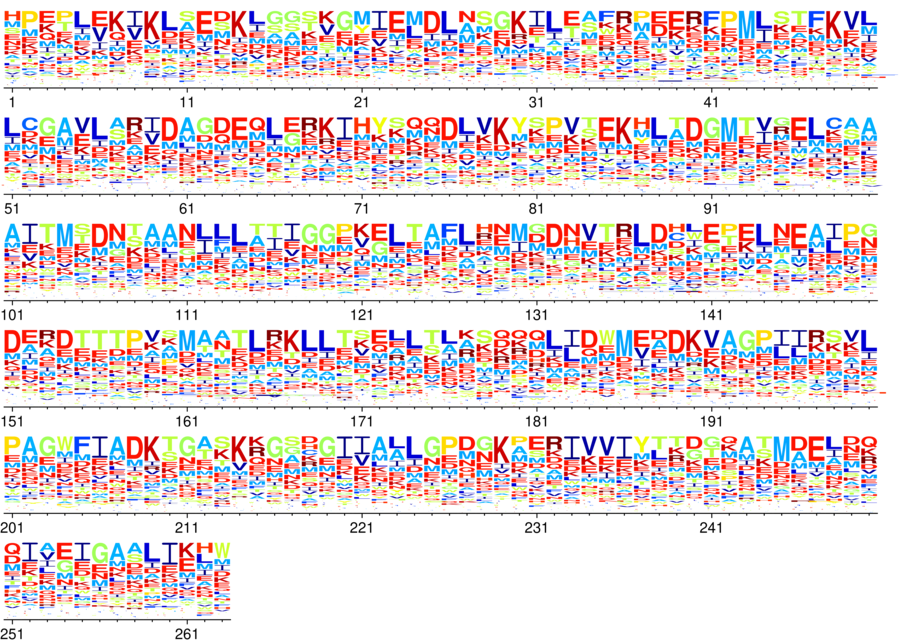

In [3]:
from IPython.display import display
from wand.image import Image as WImage

output_path = "pb_mpi_chain"
preferences_logoplot = '{0}_preferences.pdf'.format(output_path)

img = WImage(filename=preferences_logoplot, resolution=1024)
img.transform(resize='900x')
display(img)